## Importing Essential Libraries

In [8]:
import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

## Data PreProcessing

#LoadData

In [ ]:
df = pd.read_csv('train.csv')
print(df.head())

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

In [ ]:
# Handling Null values
df.isnull().sum()

In [23]:
# Dropping null values
df = df.dropna()

In [ ]:
df.isnull().sum()

In [ ]:
# Manage duplicate values
df.duplicated().sum() 
# No duplicate values


In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for numeric columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define outliers as those falling outside 1.5*IQR
outliers = (df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))

# Print the number of outliers per column
print(outliers.sum())

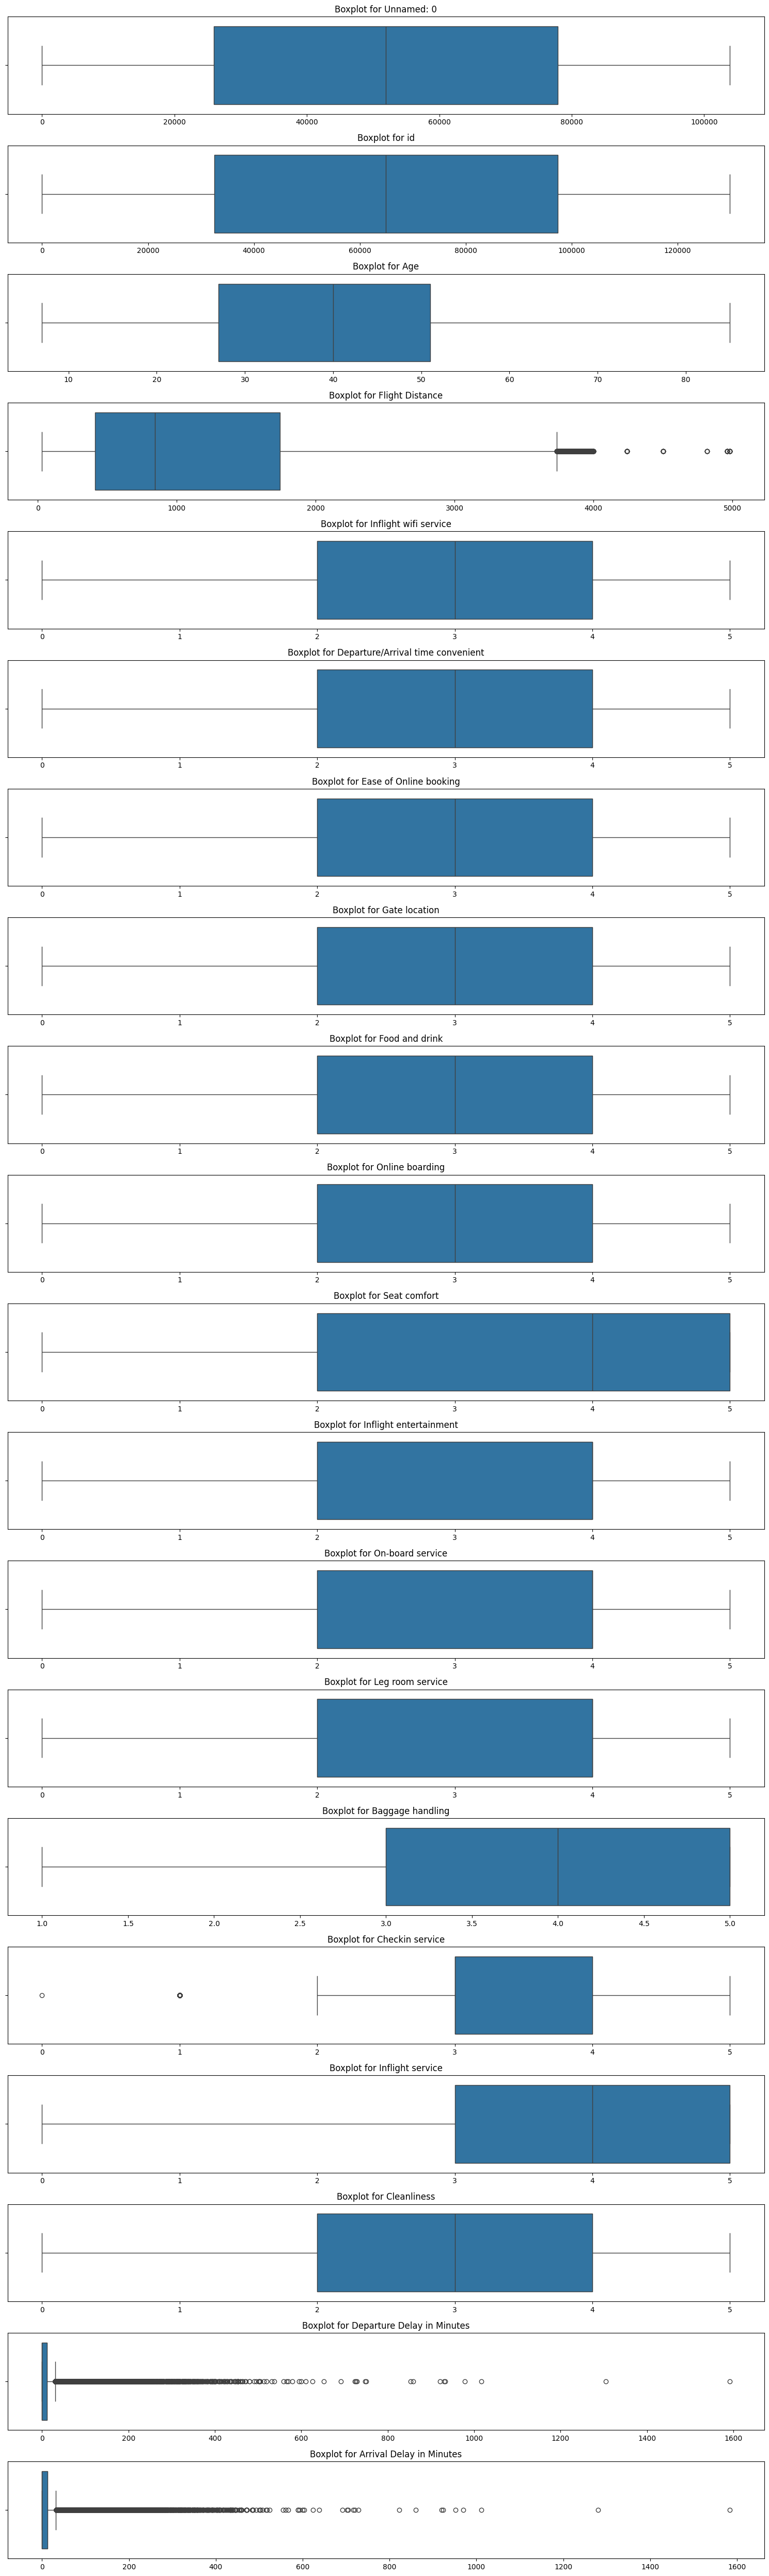

In [26]:
# we have to treat 4 coloumns as outliers
# Removing outlier is not a good option as it will affect the accuracy of the model due to high number of outliers
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Create subplots with a number of rows equal to the number of numeric columns
fig, axs = plt.subplots(len(numeric_cols), 1, figsize=(15, len(numeric_cols) * 2.5))

# Ensure axs is iterable, even if there's only one numeric column
if len(numeric_cols) == 1:
    axs = [axs]

# Plot each numeric column in a separate subplot
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Boxplot for {col}')
    axs[i].set_xlabel('')  # Optional: remove x-axis label for cleaner plots

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
